# Create climatology and persistence forecasts

In this note book we will create the most basic baselines: persistence and climatology forecasts.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [9]:
sns.set_style('darkgrid')
sns.set_context('notebook')

## Load data

First, we need to specify the directories and load the data.

In [10]:
DATADIR = '/data/weather-benchmark/5.625deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [11]:
# Load the entire dataset
z500 = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords').z
t850 = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').t

In [12]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')

## Persistence

Persistence simply means: Tomorrow's weather is today's weather.

In [13]:
def create_persistence_forecast(da, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    da_fc = da.isel(time=slice(0, -lead_time_h))
    return da_fc

In [14]:
lead_times = lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)})

In [27]:
t850

<xarray.DataArray 't' (time: 350640, lat: 32, lon: 64)>
dask.array<concatenate, shape=(350640, 32, 64), dtype=float32, chunksize=(8784, 32, 64)>
Coordinates:
    level    int32 850
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [26]:
create_persistence_forecast(z500_valid, 6)

<xarray.DataArray 'z' (time: 17514, lat: 32, lon: 64)>
dask.array<getitem, shape=(17514, 32, 64), dtype=float32, chunksize=(8760, 32, 64)>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [15]:
z500_persistence = []
for l in lead_times:
    z500_persistence.append(create_persistence_forecast(z500_valid, int(l)))
z500_persistence = xr.concat(z500_persistence, dim=lead_times)

In [16]:
t850_persistence = []
for l in lead_times:
    t850_persistence.append(create_persistence_forecast(t850_valid, int(l)))
t850_persistence = xr.concat(t850_persistence, dim=lead_times)

In [17]:
z500_persistence

<xarray.DataArray 'z' (lead_time: 20, time: 17514, lat: 32, lon: 64)>
dask.array<concatenate, shape=(20, 17514, 32, 64), dtype=float32, chunksize=(1, 8760, 32, 64)>
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
    None       (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

The forecast files have dimensions `[init_time, lead_time, lat, lon]`. Let's now save these files so we can evaluate them later.

In [18]:
persistence = xr.Dataset({'z': z500_persistence, 't': t850_persistence})

In [19]:
persistence

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, lon: 64, time: 17514)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
    None       (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
    level      int32 850
Data variables:
    z          (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>
    t          (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>

In [21]:
persistence.to_netcdf(f'{PREDDIR}persistence.nc')

In [22]:
!ncinfo $PREDDIR/persistence.nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lead_time(20), lat(32), lon(64), time(17514)
    variables(dimensions): int64 lead_time(lead_time), float64 lat(lat), float64 lon(lon), int64 time(time), int64 __values__(lead_time), int32 level(), float32 z(lead_time,time,lat,lon), float32 t(lead_time,time,lat,lon)
    groups: 


## Climatology

First let's create a single climatology from the entire training dataset (meaning everything before 2017).

In [14]:
def create_climatology_forecast(da_train):
    return da_train.mean('time')

In [15]:
z500_train = z500.sel(time=slice(None, '2016'))
t850_train = t850.sel(time=slice(None, '2016'))

In [16]:
z500_climatology = create_climatology_forecast(z500_train)
t850_climatology = create_climatology_forecast(t850_train)

In [17]:
z500_climatology

<xarray.DataArray 'z' (lat: 32, lon: 64)>
dask.array<mean_agg-aggregate, shape=(32, 64), dtype=float32, chunksize=(32, 64)>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4

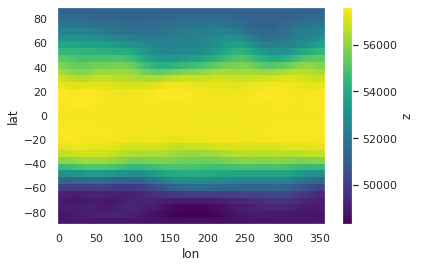

In [18]:
z500_climatology.plot();

In [19]:
climatology = xr.Dataset({'z': z500_climatology, 't': t850_climatology})

In [20]:
climatology.to_netcdf(f'{PREDDIR}climatology.nc')

## Climatology by week

We can create amuch better climatology by taking the seasonal cycle into account. Here we will do this by creating a separate climatology for every week.

In [21]:
def create_weekly_climatology_forecast(da_train, valid_time):
    da_train['week'] = da_train['time.week']
    weekly_averages = da_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [22]:
z500_weekly_climatology = create_weekly_climatology_forecast(z500_train, z500_valid.time)
t850_weekly_climatology = create_weekly_climatology_forecast(t850_train, z500_valid.time)

In [23]:
z500_weekly_climatology

<xarray.DataArray 'z' (time: 17520, lat: 32, lon: 64)>
dask.array<concatenate, shape=(17520, 32, 64), dtype=float32, chunksize=(1, 32, 64)>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    week     (time) int64 52 52 52 52 52 52 52 52 52 52 ... 1 1 1 1 1 1 1 1 1 1
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00

In [24]:
weekly_climatology = xr.Dataset({'z': z500_weekly_climatology, 't': t850_weekly_climatology})

In [25]:
weekly_climatology.to_netcdf(f'{PREDDIR}weekly_climatology.nc')

# The End